In [36]:
%matplotlib inline
# packages to load 
# Check the versions of libraries
# Python version
import warnings
warnings.filterwarnings('ignore')
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

# Importing metrics for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import random as rn
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers
from keras.callbacks import (TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from biosppy.signals import (ecg, tools)
import pywt
from tqdm import tqdm_notebook as tqdm

import math
from itertools import product
# ============= CONSTS =============
TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

seed=42
NUM_MAX_POINTS = 18154
SAMPLING_RATE=1000

# ============= CONSTS =============

np.random.seed(seed)
rn.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



Python: 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
scipy: 1.1.0


In [2]:
#Load train and test set
my_cols = ["id"] + ["x" + str(i) for i in range(NUM_MAX_POINTS)]

train_data = pd.read_csv(TRAIN_FILE_PATH, names=my_cols)[1:]
train_data.drop("id", axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop("id", axis=1, inplace = True)

test_data =  pd.read_csv(TEST_FILE_PATH, names=my_cols)[1:]
id_test = test_data.columns[0]
test_data.drop("id", axis=1, inplace=True)

In [53]:
## ================ FUNCTION DEFS ================ ##

def make_submission(filename, predictions):
    test_data =  pd.read_csv(TEST_FILE_PATH, names=my_cols)[1:]
    test_data["y"] = predictions
    test_data[["id", "y"]].to_csv("submissions/"+filename, index= False)
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

def get_feature_from_raw(signal, sampling_rate):
    # filter signal
    order = int(0.3 * sampling_rate)
    filtered, _, _ = tools.filter_signal(signal=signal,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)

    # segment
    rpeaks, = ecg.hamilton_segmenter(signal=filtered, sampling_rate=sampling_rate)

    # correct R-peak locations
    rpeaks, = ecg.correct_rpeaks(signal=filtered,
                             rpeaks=rpeaks,
                             sampling_rate=sampling_rate,
                             tol=0.05)

    # extract templates
    templates, rpeaks = ecg.extract_heartbeats(signal=filtered,
                                           rpeaks=rpeaks,
                                           sampling_rate=sampling_rate,
                                           before=0.2,
                                           after=0.4)
    return templates
    

In [4]:
print(train_data.shape)
print(Y_train.shape)

(5117, 18154)
(5117, 1)


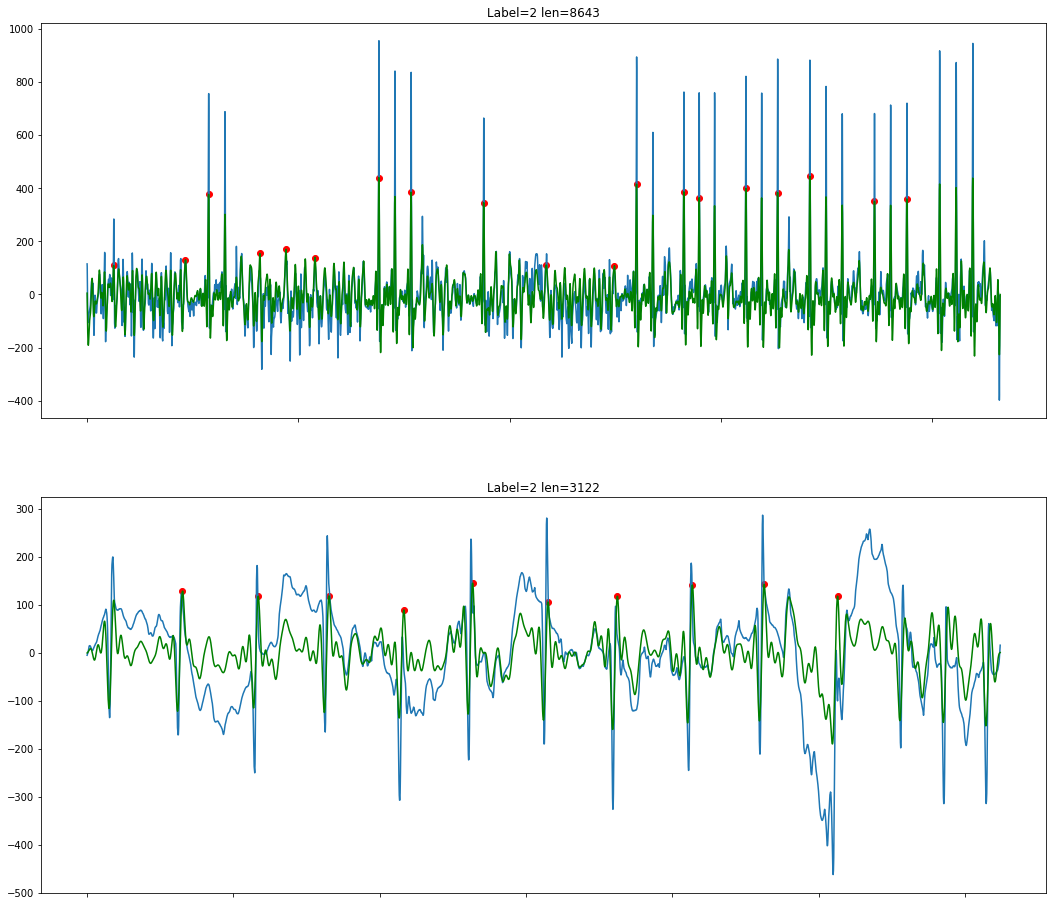

In [55]:
# plot n random entries
plt_count = 2
ids = np.random.randint(train_data.shape[0], size=plt_count)
fig, ax = plt.subplots(nrows=plt_count, figsize=(18, 16))
i = 0
for id in ids:
    row = train_data.iloc[id].dropna()
    out = ecg.ecg(signal=row.values, show=False)
    
    label = Y_train["y"][id]
    ax[i].set_title("Label={} len={}".format(label, row.count()))
    row.plot(ax=ax[i])
    # filtered
    filtered_sig = out[1]
    r_peak_index = out[2]
    ax[i].plot(filtered_sig, color='green')
    # r peaks
    ax[i].scatter(r_peak_index, [filtered_sig[i] for i in r_peak_index], color='red', marker="o")
    i += 1


In [43]:
features = list()
sampling_rate = float(SAMPLING_RATE)
for id in tqdm(range(train_data.shape[0])):
    features.append(
        get_feature_from_raw(pd.to_numeric(train_data.iloc[id].dropna()), sampling_rate)
    )

    

y = np.array(y)

In [49]:
print(len(features[45]))

34


In [51]:
# precrosses 
X_features = list ()
y = list()
for idx, sig in enumerate(features):
    mean = 0
    cnt = 0
    
    for p in sig:
        mean += p
        cnt += 1
    if cnt > 0:
        X_features.append(mean / cnt)
        y.append(Y_train.iloc[idx])
    else:
        print("{}: Cnt is equal to zero".format(idx))
    
X, _ = pywt.dwt(X_features, 'db1')
y = np.array(y)

4235: Cnt is equal to zero
5028: Cnt is equal to zero


# Get features from test data

In [54]:
features_test = list()
for id in tqdm(range(test_data.shape[0])):
    features_test.append(
        get_feature_from_raw(pd.to_numeric(test_data.iloc[id].dropna()), sampling_rate)
    )

    
        
X_features_test = list ()
for sig in features_test:
    mean = 0
    cnt = 0
    for p in sig:
        mean += p
        cnt += 1
    X_features_test.append(mean / cnt)
    
X_test, _ = pywt.dwt(X_features_test, 'db1')

# Do predictions with SVC

In [55]:
print(X.shape)
print(y.shape)
clf = SVC(gamma='auto')
clf.fit(X, y)
predicted = clf.predict(X_test)
make_submission('ax_SVC.csv', predicted)

(5115, 300)
(5115, 1)
